In [11]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from datetime import datetime
from pprint import pprint

#Crimes_2012-2015
#https://catalog.data.gov/dataset/crimes-2012-2015

# 935259 Rows
# 2012 - 2015
#Header = Date.Rptd, DR.NO,DATE.OCC,TIME.OCC,AREA,AREA.NAME,RD,Crm.Cd,CrmCd.Desc,Status,Status.Desc,
#            LOCATION,Cross.Street,Location.1
#AREA.NAME = districten

years =[]

#import dataset (pas locatie aan)
#filter header eruit
crime_data = (sc.textFile('../data/crimesLA/Crimes_2012-2015.csv').filter(lambda line: 'DATE.OCC' not in line))

year12 = crime_data.filter(lambda line: '/2012'  in line)
year13 = crime_data.filter(lambda line: '/2013'  in line)
year14 = crime_data.filter(lambda line: '/2014'  in line)
year15 = crime_data.filter(lambda line: '/2015'  in line)

years.append(year12)
years.append(year13)
years.append(year14)
years.append(year15)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# x_axis = [ for i in range(12, 16, 1)]

x_axis = range(2012,2016)
y_axis = []

for i in range(0, 4):
    y_axis.append(years[i].count())
    print years[i].count()

238117
239731
240449
228443


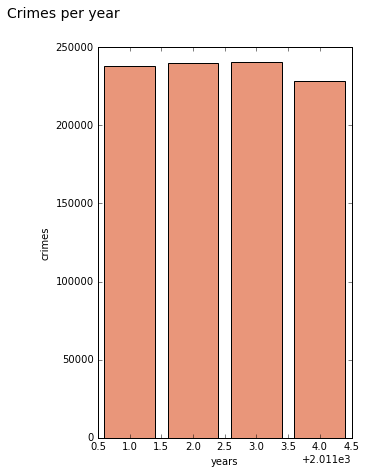

In [13]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Crimes per year', fontsize=14)
ax = fig.add_subplot(122)
ax.set_xlabel('years')
ax.set_ylabel('crimes')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

In [14]:
personCrimesid = [952,231,230,624,622,623,860,840,870,235,627,813,237,922,812,110,930,943,753,886,434,111,830,940,236,626,
                763,250,251,821,845,810,815,850,910,882,884,435,820,933,625,888,756,113,121,932,762]
propertyCrimesid = [648,480,487,942,949,662,664,310,330,654,653,660,951,950,345,444,668,670,349,347,924,331,420,354,440,473,474,350,341,647,470,471,740,745,510,442,
                    343,430,431,446,352,805,661,210,351,931]
inchoateCrimesid = [220,485,761,666,320,410,944,954,445,421,450,441,475,520,443,920,452,436,451,122,928,930]
statutoryCrimesid = [948,755,903,880,649,652,651,433,865,353,439,900,901,902,806,437,438,956,946,814,822]
trafficCrimesid = [997,890]

def parse_interaction(line):
    elems = line.split(",")
    crimeId = int(elems[7])
    if crimeId in personCrimesid:
        return ("personCrimes", elems)
    elif crimeId in propertyCrimesid:
        return ("propertyCrimes", elems)
    elif crimeId in inchoateCrimesid:
        return ("inchoateCrimes", elems)
    elif crimeId in statutoryCrimesid:
        return ("statutoryCrimes", elems)
    elif crimeId in traficCrimesid:
        return ("trafficCrimes", elems)
    else:
        return ("None", None)

key_crimes_data = year12.map(parse_interaction)

person_crimes_data = key_crimes_data.filter(lambda x: x[0]=="personCrimes")
print person_crimes_data.take(5)
# Geeft alle data weer van personCrimes
# [('personCrimes', [u'12/31/2012', u'120101612', u'12/31/2012', u'2250', u'1', u'Central', u'156', u'230', u'"ASSAULT WITH DEADLY WEAPON', u' AGGRAVATED ASSAULT"', u'AA', u'Adult Arrest', u' WALL ST', u'5TH ST', u'"(34.0449', u' -118.2458)"'])]

# print key_crimes_data.countByKey()
# Geeft:
# defaultdict(<type 'int'>, {'traficCrimes': 37835, 'propertyCrimes': 128216, 'inchoateCrimes': 4740, 'personCrimes': 55543, 'statutoryCrimes': 11783})

[('personCrimes', [u'12/31/2012', u'120101612', u'12/31/2012', u'2250', u'1', u'Central', u'156', u'230', u'"ASSAULT WITH DEADLY WEAPON', u' AGGRAVATED ASSAULT"', u'AA', u'Adult Arrest', u'         WALL                         ST', u'   5TH                          ST', u'"(34.0449', u' -118.2458)"']), ('personCrimes', [u'01/03/2013', u'120101614', u'12/31/2012', u'1830', u'1', u'Central', u'191', u'930', u'CRIMINAL THREATS - NO WEAPON DISPLAYED', u'IC', u'Invest Cont', u' 1400    WRIGHT                       ST', u'', u'"(34.0398', u' -118.2726)"']), ('personCrimes', [u'12/31/2012', u'120126226', u'12/31/2012', u'755', u'1', u'Central', u'127', u'230', u'"ASSAULT WITH DEADLY WEAPON', u' AGGRAVATED ASSAULT"', u'IC', u'Invest Cont', u'         ALAMEDA                      ST', u'   TEMPLE                       ST', u'"(34.0511', u' -118.2381)"']), ('personCrimes', [u'12/31/2012', u'120126248', u'12/31/2012', u'1550', u'1', u'Central', u'162', u'888', u'TRESPASSING', u'IC', u'Invest Cont

In [16]:
import pandas as pd

person_crimes = key_crimes_data.filter(lambda x: x[0]=="personCrimes")
person_crimes_time = person_crimes.map(lambda x: int(x[1][3]) / 100)
# person_crimes_time.collect()

property_crimes = key_crimes_data.filter(lambda x: x[0]=="propertyCrimes")
property_crimes_time = property_crimes.map(lambda x: int(x[1][3]) / 100)

inchoate_crimes = key_crimes_data.filter(lambda x: x[0]=="inchoateCrimes")
inchoate_crimes_time = inchoate_crimes.map(lambda x: int(x[1][3]) / 100)

statutory_crimes = key_crimes_data.filter(lambda x: x[0]=="statutoryCrimes")
statutory_crimes_time = statutory_crimes.map(lambda x: int(x[1][3]) / 100)

traffic_crimes = key_crimes_data.filter(lambda x: x[0]=="trafficCrimes")
traffic_crimes_time = traffic_crimes.map(lambda x: int(x[1][3]) / 100)

personCrimes_time = pd.Series(person_crimes_time.collect()).value_counts().sort_index()
#print personCrimes_time
propertyCrimes_time = pd.Series(property_crimes_time.collect()).value_counts().sort_index()
inchoateCrimes_time = pd.Series(inchoate_crimes_time.collect()).value_counts().sort_index()
statutoryCrimes_time = pd.Series(statutory_crimes_time.collect()).value_counts().sort_index()
trafficCrimes_time = pd.Series(traffic_crimes_time.collect()).value_counts().sort_index()

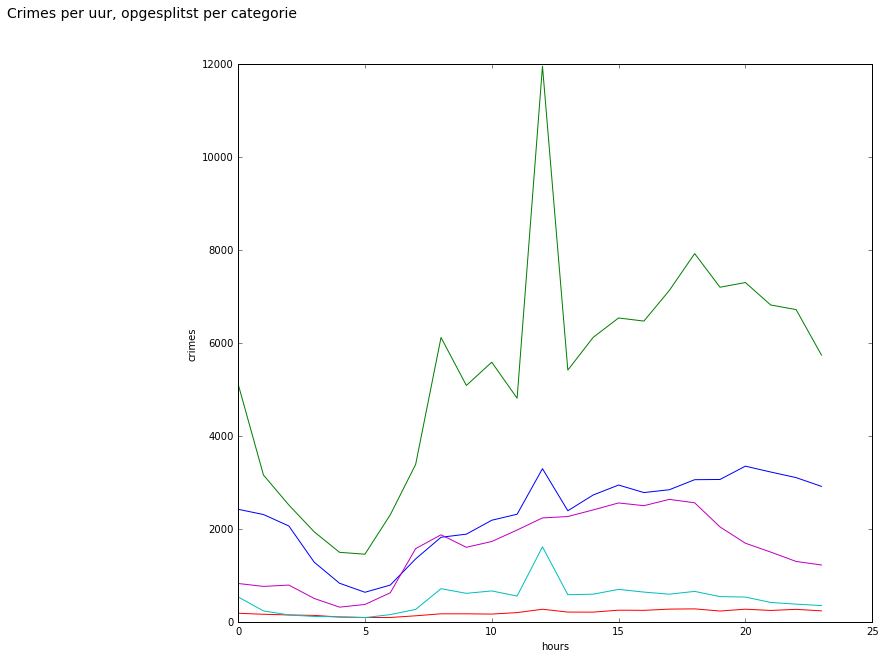

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 10))
fig.suptitle('Crimes per uur, opgesplitst per categorie', fontsize=14)

# plt1 = fig.add_subplot(121)
# plt1.set_ylabel('crimes')
# plt1.set_xlabel('hours')
# plt1.plot(personCrimes_time)

plt = fig.add_subplot(122)
plt.set_ylabel('crimes')
plt.set_xlabel('hours')
plt.plot(personCrimes_time)
plt.plot(propertyCrimes_time)
plt.plot(inchoateCrimes_time)
plt.plot(statutoryCrimes_time)
plt.plot(trafficCrimes_time)

In [19]:
from IPython.display import HTML
import folium, re

crimes = ["personCrimes", "propertyCrimes", "inchoateCrimes", "statutoryCrimes", "trafficCrimes"]

map_view = folium.Map(location=[33.9522, -118.0598], zoom_start=11)

def parse_coords(line):
    line_lenght = len(line[1])
    try:
        lat_coord = re.sub('[\"\(\) ]', '', line[1][line_lenght-2])
        long_coord = re.sub('[\"\(\) ]', '', line[1][line_lenght-1])
        return (float(lat_coord), float(long_coord))
    except:
        return (None, None)

for crime in crimes:
    try:
        crime_data = key_crimes_data.filter(lambda x: x[0]==crime)
        crime_data_coords = crime_data.map(parse_coords)
        
        if crime=="personCrimes":
            c = "blue"
            p = "Person crime"
        elif crime=="propertyCrimes":
            c = "green"
            p = "Property crime"
        elif crime=="inchoateCrimes":
            c = "cyan"
            p = "Inchoate crime"
        elif crime=="statutoryCrimes":
            c = "yellow"
            p = "Statutory crime"
        elif crime=="trafficCrimes":
            c = "magenta"
            p = "Traffic crime"
        else:
            c = "red"
            p = "None"
    
        r = 1
        for coords in crime_data_coords.distinct().take(100):
            map_view.circle_marker(location=[coords[0], coords[1]], radius=r, popup=p, line_color=c, fill_color=c)
    except:
        pass

# Prints the map
map_view

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
